# Автоматическая генерация грамматических и лексических упражнений по финскому языку

### **Цель проекта**
Создать систему для автоматической генерации упражнений по финскому языку на основе корпуса текстов. Упражнения направлены на изучение лексики и грамматики, включая работу с формами слов, темами и синтаксическими конструкциями.

**Этапы проекта**
1. Сбор и предобработка корпуса текстов
-- Сбор новостных и художественных текстов.

-- Очистка текста от лишних элементов (ссылки, пунктуация).

-- Лемматизация и удаление стоп-слов.
2. Анализ корпуса

-- Кластеризация слов с использованием векторных представлений.

-- Тематическое моделирование

-- Извлечение пар (глагол + существительное).

3. Генерация упражнений

Упражнение 1: Выбери пропущенное слово.

Упражнение 2: Определи грамматическую форму слова.

Упражнение 3: Поставь слово в нужную форму.

Упражнение 4: Найди ошибку в предложении.

Упражнение 5: Определи тему по словам.

Упражнение 6: Найди "лишнее" слово.

Упражнение 7: Ключевые слова текста (TF-IDF).

Упражнение 8: Найди предложения с заданной грамматической конструкцией.

Упражнение 9: Выбери правильное слово из очень похожих.

Упражнение 10: Упражнение на ректио (правильная форма слова после глагола).

## 1. Сбор корпуса

Корпус был собран из новостных и художественных текстов. В рамках новостных текстов я старалась подбирать такие сайты, чтобы новости были тематически разные, однако некоторые темы все-таки немного перевешивали.

Более подробно о сборе корпуса:

https://colab.research.google.com/drive/1eaAGW29JolWFnyFhpAoJ6nF7JfE8Rw__?usp=sharing

## 2. Предобработка текста

Устанавливаю все необходимые библиотеки. Постаралась вынести большинство вперед, чтобы они не мешали восприятию собственно кода (но, возможно, по мере надобности некоторые будут подгружаться)

In [ ]:
!pip install stanza

In [ ]:
!pip install bertopic

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import re
import random
from collections import Counter
from tqdm import tqdm
import stanza
import nltk
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

Инициализирую инструменты, подгружаю необходимые модели.

In [ ]:
stanza.download('fi')
nlp = stanza.Pipeline(lang='fi', processors='tokenize,mwt,pos,lemma,depparse', use_gpu=True)
sent_tokenizer = stanza.Pipeline("fi", processors="tokenize", use_gpu=True)

#скачиваю стоп-слова для финского языка из nltk (но я буду их дополнять своими ниже)
nltk.download('punkt')
nltk.download('stopwords')
finnish_stopwords = set(stopwords.words('finnish'))

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: fi (Finnish) ...


INFO:stanza:Downloaded file to /root/stanza_resources/fi/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: fi (Finnish):
| Processor | Package      |
----------------------------
| tokenize  | tdt          |
| mwt       | tdt          |
| pos       | tdt_charlm   |
| lemma     | tdt_nocharlm |
| depparse  | tdt_charlm   |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: fi (Finnish):
| Processor | Package |
-----------------------
| tokenize  | tdt     |
| mwt       | tdt     |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Done loading processors!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Пути к файлам:

In [ ]:
#исходный корпус
INPUT_PATH = "complete_corpus.csv"
#корпус после лемматизации
OUTPUT_PATH = "lemmatized_corpus.csv"
#слова по кластерам
CLUSTERED_PATH = "clustered_words_with_themes.csv"

Регистрирую tqdm, чтобы отслеживать прогресс процессов

In [ ]:
tqdm.pandas()

Предобрабатываю текст, очищаю его от "мусора"

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+|\.fi\b", "", text)  # удаление ссылок
    text = re.sub(r"\(.*?\)|\[.*?\]", "", text)  # удаление содержимого в скобках
    text = re.sub(r"^[^:]{1,30}:\s*", "", text)  # удаление слова до двоеточия
    text = re.sub(r"[^\w\säöå]", "", text)  # оставляем только финские буквы, цифры и пунктуацию удаляем
    text = re.sub(r"Kuva:.*?(\n|$)|osoitteessa.*|sivulla.*", "", text, flags=re.IGNORECASE) #удаляю неинформативные предложения, слова из газет
    text = re.sub(r"\s+", " ", text).strip()  #удаление лишних пробелов
    return text

### ЛЕММАТИЗАЦИЯ

Для каждого слова я буду извлекать лемму, часть речи, синтаксическую связь (deprel) и связь с главным словом (head) -- таким образом функция возвращает 4 значения: строку из лемм, строку из POS-тэгов, строку из зависимостей и список словарей с синтаксической информацией по каждому слову (все это пригодится мне дальше, поэтому сохраняем в самом начале)

In [ ]:
def lemmatize_finnish(text):
    #запускаю анализ с помощью stanzа: она делит текст на предложения, слова, и мы получаем морфо-синтаксическую разметку
    doc = nlp(text)
    #создаю списки для сбора описанных выше значений
    lemmas = []
    pos_tags = []
    deprels = []
    syntax_info = []

    #прохожусь по всем предложениям и словам
    for sentence in doc.sentences:
        for word in sentence.words:
            #если stanza нашла лемму, то берем ее. если не нашла, то берем оригинальное слово. stanza между границами сложных слов ставит # -- удаляем ее.
            lemma = word.lemma if word.lemma else word.text
            lemma = lemma.replace("#", "")
            #добавляю только слова (леммы и признаки слов), которые состоят из букв (еще раз отфильтровываем числа, знаки препинания и прочий "мусор", на всякий случай)
            if lemma and lemma.isalpha():
                lemmas.append(lemma)
                pos_tags.append(word.upos)
                deprels.append(word.deprel)
            syntax_info.append({
                "id": word.id,
                "text": word.text,
                "lemma": word.lemma,
                "upos": word.upos,
                "feats": word.feats,
                "head": word.head,
                "deprel": word.deprel
            })
    return " ".join(lemmas), " ".join(pos_tags), " ".join(deprels), syntax_info

Разбиваю текст на предложения и очищаю каждое из них, чтобы избежать переполненной ОЗУ (обработка целых текстов сразу вышла слишком ресурсоемкой для stanza) + для упражнений оставляю оригинальные предложения.

In [11]:
df = pd.read_csv(INPUT_PATH)

In [26]:
all_sentences = []
sentences = []
original_indices = []

In [27]:
def split_sentences(text):
    doc = sent_tokenizer(text)
    return [sent.text for sent in doc.sentences]

In [28]:
for idx, text in tqdm(df["text"].items()):
    sents = split_sentences(text)
    all_sentences.extend(sents)
    sentences.extend([preprocess_text(s) for s in sents])
    original_indices.extend([idx] * len(sents))

new_df = pd.DataFrame({
    "original_index": original_indices,
    "sentence": all_sentences,
    "cleaned_sentence": sentences
})

print(new_df.head())

720it [00:55, 12.98it/s]

   original_index                                           sentence  \
0               0  Nordea on selvittänyt kyselytutkimuksella suom...   
1               0  Toukokuun lopussa tehty kyselytutkimus paljast...   
2               0  Kyselyn mukaan suomalaiset käyttävät kesälomaa...   
3               0  Yli puolet suomalaisista suunnittelee matkusta...   
4               0  Enemmistölläsuomalaisista kotitalouksista kesä...   

                                    cleaned_sentence  
0  nordea on selvittänyt kyselytutkimuksella suom...  
1  toukokuun lopussa tehty kyselytutkimus paljast...  
2  kyselyn mukaan suomalaiset käyttävät kesälomaa...  
3  yli puolet suomalaisista suunnittelee matkusta...  
4  enemmistölläsuomalaisista kotitalouksista kesä...  


Собственно лемматизация и сохранение POS и зависимостей

Дробим наш корпус на части (чанки), чтобы опять же избежать переполнения ОЗУ и если что сохранить хотя бы часть корпуса и начать с места, где остановились.

В каждом проходе из моего массива sentences берется кусок от start до end, и на каждое предложение применяется функция lemmatize_finnish, описанная ранее.
Результаты посылаю в chunk_df и добавляю к общему датафрейму.
После обработки каждого чанка данные сохраняются в файл OUTPUT_PATH на случай прерывания сессии.

In [29]:
from pathlib import Path

In [33]:
if Path(OUTPUT_PATH).exists():
    df_done = pd.read_csv(OUTPUT_PATH)
    start_index = len(df_done)
    print(f"Продолжаем с {start_index}")
else:
    df_done = pd.DataFrame()
    start_index = 0

chunk_size = 500

for start in range(start_index, len(sentences), chunk_size):
    end = min(start + chunk_size, len(sentences))
    print(f"\nОбработка предложений {start} — {end}")

    chunk = sentences[start:end]
    all_data = []

    for sent in tqdm(chunk):
        lemmas, pos_tags, deprels, syntax = lemmatize_finnish(sent)
        all_data.append({
            "text": sent,
            "lemmatized_text": lemmas,
            "pos_sequence": pos_tags,
            "deprel_sequence": deprels,
            "syntax_info": syntax
        })

    chunk_df = pd.DataFrame(all_data)
    df_done = pd.concat([df_done, chunk_df], ignore_index=True)
    df_done.to_csv(OUTPUT_PATH, index=False)
    print(f"Сохранено {len(df_done)}")


Обработка предложений 0 — 500


100%|██████████| 500/500 [00:47<00:00, 10.50it/s]


Сохранено 500

Обработка предложений 500 — 1000


100%|██████████| 500/500 [00:46<00:00, 10.82it/s]


Сохранено 1000

Обработка предложений 1000 — 1500


100%|██████████| 500/500 [00:46<00:00, 10.82it/s]


Сохранено 1500

Обработка предложений 1500 — 2000


100%|██████████| 500/500 [00:45<00:00, 10.89it/s]


Сохранено 2000

Обработка предложений 2000 — 2500


100%|██████████| 500/500 [00:48<00:00, 10.24it/s]


Сохранено 2500

Обработка предложений 2500 — 3000


100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


Сохранено 3000

Обработка предложений 3000 — 3500


100%|██████████| 500/500 [00:49<00:00, 10.18it/s]


Сохранено 3500

Обработка предложений 3500 — 4000


100%|██████████| 500/500 [00:47<00:00, 10.43it/s]


Сохранено 4000

Обработка предложений 4000 — 4500


100%|██████████| 500/500 [00:48<00:00, 10.25it/s]


Сохранено 4500

Обработка предложений 4500 — 5000


100%|██████████| 500/500 [00:48<00:00, 10.41it/s]


Сохранено 5000

Обработка предложений 5000 — 5500


100%|██████████| 500/500 [00:49<00:00, 10.11it/s]


Сохранено 5500

Обработка предложений 5500 — 6000


100%|██████████| 500/500 [00:54<00:00,  9.21it/s]


Сохранено 6000

Обработка предложений 6000 — 6500


100%|██████████| 500/500 [00:46<00:00, 10.83it/s]


Сохранено 6500

Обработка предложений 6500 — 7000


100%|██████████| 500/500 [00:48<00:00, 10.23it/s]


Сохранено 7000

Обработка предложений 7000 — 7500


100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


Сохранено 7500

Обработка предложений 7500 — 8000


100%|██████████| 500/500 [00:46<00:00, 10.73it/s]


Сохранено 8000

Обработка предложений 8000 — 8500


100%|██████████| 500/500 [00:45<00:00, 10.98it/s]


Сохранено 8500

Обработка предложений 8500 — 9000


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


Сохранено 9000

Обработка предложений 9000 — 9500


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


Сохранено 9500

Обработка предложений 9500 — 10000


100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


Сохранено 10000

Обработка предложений 10000 — 10500


100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


Сохранено 10500

Обработка предложений 10500 — 11000


100%|██████████| 500/500 [00:44<00:00, 11.19it/s]


Сохранено 11000

Обработка предложений 11000 — 11500


100%|██████████| 500/500 [00:44<00:00, 11.22it/s]


Сохранено 11500

Обработка предложений 11500 — 12000


100%|██████████| 500/500 [00:45<00:00, 11.00it/s]


Сохранено 12000

Обработка предложений 12000 — 12500


100%|██████████| 500/500 [00:46<00:00, 10.84it/s]


Сохранено 12500

Обработка предложений 12500 — 13000


100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


Сохранено 13000

Обработка предложений 13000 — 13500


100%|██████████| 500/500 [00:45<00:00, 11.08it/s]


Сохранено 13500

Обработка предложений 13500 — 14000


100%|██████████| 500/500 [00:44<00:00, 11.13it/s]


Сохранено 14000

Обработка предложений 14000 — 14500


100%|██████████| 500/500 [00:47<00:00, 10.60it/s]


Сохранено 14500

Обработка предложений 14500 — 15000


100%|██████████| 500/500 [00:48<00:00, 10.22it/s]


Сохранено 15000

Обработка предложений 15000 — 15500


100%|██████████| 500/500 [00:48<00:00, 10.37it/s]


Сохранено 15500

Обработка предложений 15500 — 16000


100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


Сохранено 16000

Обработка предложений 16000 — 16500


100%|██████████| 500/500 [00:48<00:00, 10.26it/s]


Сохранено 16500

Обработка предложений 16500 — 17000


100%|██████████| 500/500 [00:45<00:00, 10.96it/s]


Сохранено 17000

Обработка предложений 17000 — 17500


100%|██████████| 500/500 [00:45<00:00, 11.10it/s]


Сохранено 17500

Обработка предложений 17500 — 18000


100%|██████████| 500/500 [00:46<00:00, 10.73it/s]


Сохранено 18000

Обработка предложений 18000 — 18500


100%|██████████| 500/500 [00:46<00:00, 10.86it/s]


Сохранено 18500

Обработка предложений 18500 — 19000


100%|██████████| 500/500 [00:44<00:00, 11.29it/s]


Сохранено 19000

Обработка предложений 19000 — 19500


100%|██████████| 500/500 [00:45<00:00, 11.03it/s]


Сохранено 19500

Обработка предложений 19500 — 20000


100%|██████████| 500/500 [00:47<00:00, 10.55it/s]


Сохранено 20000

Обработка предложений 20000 — 20500


100%|██████████| 500/500 [00:44<00:00, 11.36it/s]


Сохранено 20500

Обработка предложений 20500 — 21000


100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


Сохранено 21000

Обработка предложений 21000 — 21500


100%|██████████| 500/500 [00:45<00:00, 11.02it/s]


Сохранено 21500

Обработка предложений 21500 — 22000


100%|██████████| 500/500 [00:31<00:00, 16.01it/s]


Сохранено 22000

Обработка предложений 22000 — 22500


100%|██████████| 500/500 [00:33<00:00, 14.84it/s]


Сохранено 22500

Обработка предложений 22500 — 23000


100%|██████████| 500/500 [00:37<00:00, 13.32it/s]


Сохранено 23000

Обработка предложений 23000 — 23500


100%|██████████| 500/500 [00:32<00:00, 15.49it/s]


Сохранено 23500

Обработка предложений 23500 — 24000


100%|██████████| 500/500 [00:32<00:00, 15.45it/s]


Сохранено 24000

Обработка предложений 24000 — 24500


100%|██████████| 500/500 [00:34<00:00, 14.38it/s]


Сохранено 24500

Обработка предложений 24500 — 25000


100%|██████████| 500/500 [00:35<00:00, 14.27it/s]


Сохранено 25000

Обработка предложений 25000 — 25500


100%|██████████| 500/500 [00:34<00:00, 14.42it/s]


Сохранено 25500

Обработка предложений 25500 — 26000


100%|██████████| 500/500 [00:36<00:00, 13.79it/s]


Сохранено 26000

Обработка предложений 26000 — 26500


100%|██████████| 500/500 [00:35<00:00, 14.04it/s]


Сохранено 26500

Обработка предложений 26500 — 27000


100%|██████████| 500/500 [00:36<00:00, 13.60it/s]


Сохранено 27000

Обработка предложений 27000 — 27500


100%|██████████| 500/500 [00:38<00:00, 12.90it/s]


Сохранено 27500

Обработка предложений 27500 — 28000


100%|██████████| 500/500 [00:33<00:00, 15.13it/s]


Сохранено 28000

Обработка предложений 28000 — 28500


100%|██████████| 500/500 [00:33<00:00, 14.81it/s]


Сохранено 28500

Обработка предложений 28500 — 29000


100%|██████████| 500/500 [00:34<00:00, 14.55it/s]


Сохранено 29000

Обработка предложений 29000 — 29500


100%|██████████| 500/500 [00:39<00:00, 12.75it/s]


Сохранено 29500

Обработка предложений 29500 — 30000


100%|██████████| 500/500 [00:35<00:00, 14.08it/s]


Сохранено 30000

Обработка предложений 30000 — 30500


100%|██████████| 500/500 [00:35<00:00, 13.95it/s]


Сохранено 30500

Обработка предложений 30500 — 31000


100%|██████████| 500/500 [00:35<00:00, 14.19it/s]


Сохранено 31000

Обработка предложений 31000 — 31500


100%|██████████| 500/500 [00:31<00:00, 15.93it/s]


Сохранено 31500

Обработка предложений 31500 — 32000


100%|██████████| 500/500 [00:31<00:00, 16.06it/s]


Сохранено 32000

Обработка предложений 32000 — 32500


100%|██████████| 500/500 [00:35<00:00, 14.22it/s]


Сохранено 32500

Обработка предложений 32500 — 33000


100%|██████████| 500/500 [00:37<00:00, 13.24it/s]


Сохранено 33000

Обработка предложений 33000 — 33500


100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


Сохранено 33500

Обработка предложений 33500 — 34000


100%|██████████| 500/500 [00:46<00:00, 10.77it/s]


Сохранено 34000

Обработка предложений 34000 — 34500


100%|██████████| 500/500 [00:44<00:00, 11.28it/s]


Сохранено 34500

Обработка предложений 34500 — 35000


100%|██████████| 500/500 [00:51<00:00,  9.66it/s]


Сохранено 35000

Обработка предложений 35000 — 35500


100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


Сохранено 35500

Обработка предложений 35500 — 36000


100%|██████████| 500/500 [00:42<00:00, 11.69it/s]


Сохранено 36000

Обработка предложений 36000 — 36500


100%|██████████| 500/500 [00:38<00:00, 12.87it/s]


Сохранено 36500

Обработка предложений 36500 — 37000


100%|██████████| 500/500 [00:47<00:00, 10.54it/s]


Сохранено 37000

Обработка предложений 37000 — 37500


100%|██████████| 500/500 [00:59<00:00,  8.34it/s]


Сохранено 37500

Обработка предложений 37500 — 38000


100%|██████████| 500/500 [00:41<00:00, 12.02it/s]


Сохранено 38000

Обработка предложений 38000 — 38500


100%|██████████| 500/500 [00:47<00:00, 10.56it/s]


Сохранено 38500

Обработка предложений 38500 — 39000


100%|██████████| 500/500 [00:57<00:00,  8.72it/s]


Сохранено 39000

Обработка предложений 39000 — 39500


100%|██████████| 500/500 [00:35<00:00, 14.14it/s]


Сохранено 39500

Обработка предложений 39500 — 40000


100%|██████████| 500/500 [00:38<00:00, 12.93it/s]


Сохранено 40000

Обработка предложений 40000 — 40500


100%|██████████| 500/500 [00:37<00:00, 13.30it/s]


Сохранено 40500

Обработка предложений 40500 — 41000


100%|██████████| 500/500 [00:36<00:00, 13.84it/s]


Сохранено 41000

Обработка предложений 41000 — 41500


100%|██████████| 500/500 [00:41<00:00, 12.08it/s]


Сохранено 41500

Обработка предложений 41500 — 42000


100%|██████████| 500/500 [00:34<00:00, 14.40it/s]


Сохранено 42000

Обработка предложений 42000 — 42500


100%|██████████| 500/500 [00:35<00:00, 14.08it/s]


Сохранено 42500

Обработка предложений 42500 — 43000


100%|██████████| 500/500 [00:35<00:00, 14.12it/s]


Сохранено 43000

Обработка предложений 43000 — 43500


100%|██████████| 500/500 [00:46<00:00, 10.87it/s]


Сохранено 43500

Обработка предложений 43500 — 44000


100%|██████████| 500/500 [00:32<00:00, 15.41it/s]


Сохранено 44000

Обработка предложений 44000 — 44500


100%|██████████| 500/500 [00:32<00:00, 15.31it/s]


Сохранено 44500

Обработка предложений 44500 — 45000


100%|██████████| 500/500 [00:32<00:00, 15.28it/s]


Сохранено 45000

Обработка предложений 45000 — 45500


100%|██████████| 500/500 [00:33<00:00, 14.77it/s]


Сохранено 45500

Обработка предложений 45500 — 46000


100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


Сохранено 46000

Обработка предложений 46000 — 46500


100%|██████████| 500/500 [00:32<00:00, 15.44it/s]


Сохранено 46500

Обработка предложений 46500 — 47000


100%|██████████| 500/500 [00:34<00:00, 14.49it/s]


Сохранено 47000

Обработка предложений 47000 — 47500


100%|██████████| 500/500 [00:34<00:00, 14.41it/s]


Сохранено 47500

Обработка предложений 47500 — 48000


100%|██████████| 500/500 [00:33<00:00, 15.13it/s]


Сохранено 48000

Обработка предложений 48000 — 48500


100%|██████████| 500/500 [00:33<00:00, 14.96it/s]


Сохранено 48500

Обработка предложений 48500 — 49000


100%|██████████| 500/500 [00:44<00:00, 11.31it/s]


Сохранено 49000

Обработка предложений 49000 — 49351


100%|██████████| 351/351 [00:23<00:00, 15.02it/s]


Сохранено 49351


In [34]:
df_done.head()

,text,lemmatized_text,pos_sequence,deprel_sequence,syntax_info
0,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."
1,toukokuun lopussa tehty kyselytutkimus paljast...,toukokuu loppu tehdä kyselytutkimus paljastaa ...,NOUN NOUN VERB NOUN VERB SCONJ ADJ NOUN AUX VE...,nmod:poss obl acl nsubj root mark amod nsubj a...,"[{'id': 1, 'text': 'toukokuun', 'lemma': 'touk..."
2,kyselyn mukaan suomalaiset käyttävät kesälomaa...,kysely mukaan suomalainen käyttää kesäloma täm...,NOUN ADP NOUN VERB NOUN PRON NOUN ADV NOUN NOU...,obl case nsubj root obj det obl advmod obj obl...,"[{'id': 1, 'text': 'kyselyn', 'lemma': 'kysely..."
3,yli puolet suomalaisista suunnittelee matkusta...,yli puoli suomalainen suunnitella matkustaa va...,ADV NOUN NOUN VERB VERB ADV NOUN CCONJ ADV ADJ...,advmod nsubj nmod root xcomp advmod obl cc adv...,"[{'id': 1, 'text': 'yli', 'lemma': 'yli', 'upo..."
4,enemmistölläsuomalaisista kotitalouksista kesä...,enemmistölläsuomalainen kotitalous kesäloma kä...,ADJ NOUN NOUN VERB ADV NOUN,amod obl obl root advmod obj,"[{'id': 1, 'text': 'enemmistölläsuomalaisista'..."


In [37]:
merged_df = pd.merge(new_df, df_done, left_on='original_index', right_index=True, how='left')

merged_df.head()

,original_index,sentence,cleaned_sentence,text,lemmatized_text,pos_sequence,deprel_sequence,syntax_info
0,0,Nordea on selvittänyt kyselytutkimuksella suom...,nordea on selvittänyt kyselytutkimuksella suom...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."
1,0,Toukokuun lopussa tehty kyselytutkimus paljast...,toukokuun lopussa tehty kyselytutkimus paljast...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."
2,0,Kyselyn mukaan suomalaiset käyttävät kesälomaa...,kyselyn mukaan suomalaiset käyttävät kesälomaa...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."
3,0,Yli puolet suomalaisista suunnittelee matkusta...,yli puolet suomalaisista suunnittelee matkusta...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."
4,0,Enemmistölläsuomalaisista kotitalouksista kesä...,enemmistölläsuomalaisista kotitalouksista kesä...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'..."


In [38]:
df = merged_df

Завожу список стоп-слов вручную: что-то из анализа результатов (например, частотные глаголы, которые не несут важной семантической нагрузки, союзы, частицы, местоимения), а также из расширенного списка стоп-слов для финского от коллег (некоторые слова он дублирует): https://github.com/stopwords-iso/stopwords-fi

In [39]:
custom_stopwords = {
    'alkaa', 'ehdoton', 'jäädä', 'kaikki', 'kertoa', 'koska', 'kuitenkin',
    'kun', 'kuten', 'kyllä', 'me', 'melko', 'mennä', 'minä', 'mutta', 'muu',
    'myös', 'ne', 'niin', 'nyt', 'nämä', 'olla', 'osa', 'piti', 'pitäisi',
    'pitää', 'saada', 'sanoa', 'se', 'sillä', 'sinä', 'sitten', 'tai', 'tarvita',
    'te', 'tehdä', 'todella', 'tulla', 'tuo', 'tämä', 'täytyy', 'usein', 'vaikka',
    'vain', 'vielä', 'voida', 'voin', 'voisi', 'vuosi'
}


additional_stopwords = ["aiemmin","aika","aikaa","aikaan","aikaisemmin","aikaisin","aikajen","aikana","aikoina","aikoo","aikovat","aina","ainakaan","ainakin","ainoa","ainoat","aiomme","aion","aiotte","aist","aivan","ajan","alas","alemmas","alkuisin","alkuun","alla","alle","aloitamme","aloitan","aloitat","aloitatte","aloitattivat","aloitettava","aloitettevaksi","aloitettu","aloitimme","aloitin","aloitit","aloititte","aloittaa","aloittamatta","aloitti","aloittivat","alta","aluksi","alussa","alusta","annettavaksi","annetteva","annettu","ansiosta","antaa","antamatta","antoi","aoua","apu","asia","asiaa","asian","asiasta","asiat","asioiden","asioihin","asioita","asti","avuksi","avulla","avun","avutta","edelle","edelleen","edellä","edeltä","edemmäs","edes","edessä","edestä","ehkä","ei","eikä","eilen","eivät","eli","ellei","elleivät","ellemme","ellen","ellet","ellette","emme","en","enemmän","eniten","ennen","ensi","ensimmäinen","ensimmäiseksi","ensimmäisen","ensimmäisenä","ensimmäiset","ensimmäisiksi","ensimmäisinä","ensimmäisiä","ensimmäistä","ensin","entinen","entisen","entisiä","entisten","entistä","enää","eri","erittäin","erityisesti","eräiden","eräs","eräät","esi","esiin","esillä","esimerkiksi","et","eteen","etenkin","etessa","ette","ettei","että","haikki","halua","haluaa","haluamatta","haluamme","haluan","haluat","haluatte","haluavat","halunnut","halusi","halusimme","halusin","halusit","halusitte","halusivat","halutessa","haluton","he","hei","heidän","heidät","heihin","heille","heillä","heiltä","heissä","heistä","heitä","helposti","heti","hetkellä","hieman","hitaasti","hoikein","huolimatta","huomenna","hyvien","hyviin","hyviksi","hyville","hyviltä","hyvin","hyvinä","hyvissä","hyvistä","hyviä","hyvä","hyvät","hyvää","hän","häneen","hänelle","hänellä","häneltä","hänen","hänessä","hänestä","hänet","häntä","ihan","ilman","ilmeisesti","itse","itsensä","itseään","ja","jo","johon","joiden","joihin","joiksi","joilla","joille","joilta","joina","joissa","joista","joita","joka","jokainen","jokin","joko","joksi","joku","jolla","jolle","jolloin","jolta","jompikumpi","jona","jonka","jonkin","jonne","joo","jopa","jos","joskus","jossa","josta","jota","jotain","joten","jotenkin","jotenkuten","jotka","jotta","jouduimme","jouduin","jouduit","jouduitte","joudumme","joudun","joudutte","joukkoon","joukossa","joukosta","joutua","joutui","joutuivat","joutumaan","joutuu","joutuvat","juuri","jälkeen","jälleen","jää","kahdeksan","kahdeksannen","kahdella","kahdelle","kahdelta","kahden","kahdessa","kahdesta","kahta","kahteen","kai","kaiken","kaikille","kaikilta","kaikkea","kaikki","kaikkia","kaikkiaan","kaikkialla","kaikkialle","kaikkialta","kaikkien","kaikkin","kaksi","kannalta","kannattaa","kanssa","kanssaan","kanssamme","kanssani","kanssanne","kanssasi","kauan","kauemmas","kaukana","kautta","kehen","keiden","keihin","keiksi","keille","keillä","keiltä","keinä","keissä","keistä","keitten","keittä","keitä","keneen","keneksi","kenelle","kenellä","keneltä","kenen","kenenä","kenessä","kenestä","kenet","kenettä","kennessästä","kenties","kerran","kerta","kertaa","keskellä","kesken","keskimäärin","ketkä","ketä","kiitos","kohti","koko","kokonaan","kolmas","kolme","kolmen","kolmesti","koska","koskaan","kovin","kuin","kuinka","kuinkan","kuitenkaan","kuitenkin","kuka","kukaan","kukin","kukka","kumpainen","kumpainenkaan","kumpi","kumpikaan","kumpikin","kun","kuten","kuuden","kuusi","kuutta","kylliksi","kyllä","kymmenen","kyse","liian","liki","lisäksi","lisää","lla","luo","luona","lähekkäin","lähelle","lähellä","läheltä","lähemmäs","lähes","lähinnä","lähtien","läpi","mahdollisimman","mahdollista","me","meidän","meidät","meihin","meille","meillä","meiltä","meissä","meistä","meitä","melkein","melko","menee","meneet","menemme","menen","menet","menette","menevät","meni","menimme","menin","menit","menivät","mennessä","mennyt","menossa","mihin","mikin","miksi","mikä","mikäli","mikään","mille","milloin","milloinkan","millä","miltä","minkä","minne","minua","minulla","minulle","minulta","minun","minussa","minusta","minut","minuun","minä","missä","mistä","miten","mitkä","mitä","mitään","moi","molemmat","mones","monesti","monet","moni","moniaalla","moniaalle","moniaalta","monta","muassa","muiden","muita","muka","mukaan","mukaansa","mukana","mutta","muu","muualla","muualle","muualta","muuanne","muulloin","muun","muut","muuta","muutama","muutaman","muuten","myöhemmin","myös","myöskin","myöskään","myötä","ne","neljä","neljän","neljää","niiden","niihin","niiksi","niille","niillä","niiltä","niin","niinä","niissä","niistä","niitä","noiden","noihin","noiksi","noilla","noille","noilta","noin","noina","noissa","noista","noita","nopeammin","nopeasti","nopeiten","nro","nuo","nyt","näiden","näihin","näiksi","näille","näillä","näiltä","näin","näinä","näissä","näissähin","näissälle","näissältä","näissästä","näistä","näitä","nämä","ohi","oikea","oikealla","oikein","ole","olemme","olen","olet","olette","oleva","olevan","olevat","oli","olimme","olin","olisi","olisimme","olisin","olisit","olisitte","olisivat","olit","olitte","olivat","olla","olleet","olli","ollut","oma","omaa","omaan","omaksi","omalle","omalta","oman","omassa","omat","omia","omien","omiin","omiksi","omille","omilta","omissa","omista","on","onkin","onko","ovat","paikoittain","paitsi","pakosti","paljon","paremmin","parempi","parhaillaan","parhaiten","perusteella","peräti","pian","pieneen","pieneksi","pienelle","pienellä","pieneltä","pienempi","pienestä","pieni","pienin","poikki","puolesta","puolestaan","päälle","runsaasti","saakka","sadam","sama","samaa","samaan","samalla","samallalta","samallassa","samallasta","saman","samat","samoin","sata","sataa","satojen","se","seitsemän","sekä","sen","seuraavat","siellä","sieltä","siihen","siinä","siis","siitä","sijaan","siksi","sille","silloin","sillä","silti","siltä","sinne","sinua","sinulla","sinulle","sinulta","sinun","sinussa","sinusta","sinut","sinuun","sinä","sisäkkäin","sisällä","siten","sitten","sitä","ssa","sta","suoraan","suuntaan","suuren","suuret","suuri","suuria","suurin","suurten","taa","taas","taemmas","tahansa","tai","takaa","takaisin","takana","takia","tallä","tapauksessa","tarpeeksi","tavalla","tavoitteena","te","teidän","teidät","teihin","teille","teillä","teiltä","teissä","teistä","teitä","tietysti","todella","toinen","toisaalla","toisaalle","toisaalta","toiseen","toiseksi","toisella","toiselle","toiselta","toisemme","toisen","toisensa","toisessa","toisesta","toista","toistaiseksi","toki","tosin","tuhannen","tuhat","tule","tulee","tulemme","tulen","tulet","tulette","tulevat","tulimme","tulin","tulisi","tulisimme","tulisin","tulisit","tulisitte","tulisivat","tulit","tulitte","tulivat","tulla","tulleet","tullut","tuntuu","tuo","tuohon","tuoksi","tuolla","tuolle","tuolloin","tuolta","tuon","tuona","tuonne","tuossa","tuosta","tuota","tuotä","tuskin","tykö","tähän","täksi","tälle","tällä","tällöin","tältä","tämä","tämän","tänne","tänä","tänään","tässä","tästä","täten","tätä","täysin","täytyvät","täytyy","täällä","täältä","ulkopuolella","usea","useasti","useimmiten","usein","useita","uudeksi","uudelleen","uuden","uudet","uusi","uusia","uusien","uusinta","uuteen","uutta","vaan","vahemmän","vai","vaiheessa","vaikea","vaikean","vaikeat","vaikeilla","vaikeille","vaikeilta","vaikeissa","vaikeista","vaikka","vain","varmasti","varsin","varsinkin","varten","vasen","vasenmalla","vasta","vastaan","vastakkain","vastan","verran","vielä","vierekkäin","vieressä","vieri","viiden","viime","viimeinen","viimeisen","viimeksi","viisi","voi","voidaan","voimme","voin","voisi","voit","voitte","voivat","vuoden","vuoksi","vuosi","vuosien","vuosina","vuotta","vähemmän","vähintään","vähiten","vähän","välillä","yhdeksän","yhden","yhdessä","yhteen","yhteensä","yhteydessä","yhteyteen","yhtä","yhtäälle","yhtäällä","yhtäältä","yhtään","yhä","yksi","yksin","yksittäin","yleensä","ylemmäs","yli","ylös","ympäri","älköön","älä"]

# объединяем два списка в одно множество для фильтрации
all_stopwords = custom_stopwords.union(set(additional_stopwords))

from collections import Counter

#убираю стоп-слова, слишком короткие слова (1-2 символа) и совсем редкие слова
def filter_lemmatized_texts(texts, freq_threshold=3):
    all_lemmas = " ".join(texts).split()
    freq = Counter(all_lemmas)

    return [
        " ".join([
            w for w in text.split()
            if w not in  all_stopwords and len(w) > 2 and freq[w] > freq_threshold
        ])
        for text in texts
    ]

#сохраняю в отдельную колонку
df["cleaned_text"] = filter_lemmatized_texts(df["lemmatized_text"])

Сохраняю корпус, отфильтрованный и предобработанный, именно из него мы будем использовать данные для кластеризации, ТМ

In [40]:
df.to_csv("filtered_corpus.csv", index=False)

In [41]:
df.head()

,original_index,sentence,cleaned_sentence,text,lemmatized_text,pos_sequence,deprel_sequence,syntax_info,cleaned_text
0,0,Nordea on selvittänyt kyselytutkimuksella suom...,nordea on selvittänyt kyselytutkimuksella suom...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'...",nordea selvittää kyselytutkimus suomalainen ke...
1,0,Toukokuun lopussa tehty kyselytutkimus paljast...,toukokuun lopussa tehty kyselytutkimus paljast...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'...",nordea selvittää kyselytutkimus suomalainen ke...
2,0,Kyselyn mukaan suomalaiset käyttävät kesälomaa...,kyselyn mukaan suomalaiset käyttävät kesälomaa...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'...",nordea selvittää kyselytutkimus suomalainen ke...
3,0,Yli puolet suomalaisista suunnittelee matkusta...,yli puolet suomalaisista suunnittelee matkusta...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'...",nordea selvittää kyselytutkimus suomalainen ke...
4,0,Enemmistölläsuomalaisista kotitalouksista kesä...,enemmistölläsuomalaisista kotitalouksista kesä...,nordea on selvittänyt kyselytutkimuksella suom...,nordea olla selvittää kyselytutkimus suomalain...,PROPN AUX VERB NOUN NOUN NOUN VERB VERB NOUN,nsubj aux root obl nmod:poss obl acl acl obj,"[{'id': 1, 'text': 'nordea', 'lemma': 'nordea'...",nordea selvittää kyselytutkimus suomalainen ke...


Удаляю решетки из сложных слов в syntax_info

In [42]:
import ast

df = pd.read_csv("filtered_corpus.csv")

df["syntax_info"] = df["syntax_info"].apply(ast.literal_eval)

def clean_lemmas(syntax_data):
    for token in syntax_data:
        if "lemma" in token and token["lemma"]:
            token["lemma"] = token["lemma"].replace("#", "")
    return syntax_data

df["syntax_info"] = df["syntax_info"].apply(clean_lemmas)

df.to_csv("filtered_corpus.csv", index=False)

## 3. Анализ корпуса

### Частотный анализ

Считаю наиболее частотные леммы в корпусе.

In [43]:
all_lemmas = " ".join(df["cleaned_text"].dropna().astype(str)).split()
lemma_counts = Counter(all_lemmas)

print("\nТоп-20 лемм:")
for lemma, count in lemma_counts.most_common(20):
    print(f"{lemma}: {count}")


Топ-20 лемм:
kylä: 19953
pohjoiskarjala: 5337
kovero: 5222
työ: 4308
tulevaisuus: 3819
näkyä: 3707
tekeminen: 3536
käsi: 3343
tapahtuma: 3192
yhteisöllisyys: 3104
heinävaara: 3007
maarianvaara: 3006
joensuu: 2985
lähteä: 2797
varkaus: 2724
sarkkinen: 2705
toiminta: 2491
kylätoiminta: 2421
monipuolinen: 2334
värtsilä: 2314


Корпус содержит множество лемм, которые фокусируются на описании сельской жизни, социальной активности в малых и средних населенных пунктах, с упором на местные и географические особенности (деревни, регионы). Это указывает на разговорно-описательный характер корпуса.

Визуализация в виде облака слов.
Еще захотелось сделать облако в цветах финского флага, так что задаю оттенки голубого и синего вручную :)

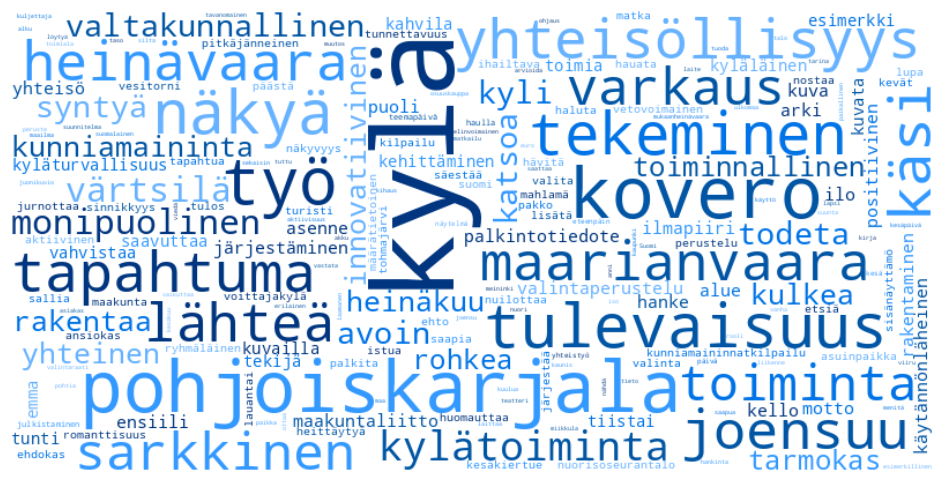

In [44]:
def finnish_flag_colors(word, font_size, position, orientation, random_state=None, **kwargs):
    blues = ["#003580", "#0055a4", "#0073e6", "#3399ff", "#66b2ff"]
    return random.choice(blues)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
).generate_from_frequencies(lemma_counts)

wordcloud.recolor(color_func=finnish_flag_colors)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4. Кластеризация

Для выделения лексико-тематических групп в корпусе я провела кластеризацию слов на основе векторных представлений, обученных с помощью модели Word2Vec

:( Однако результаты кластеризации оказались недостаточно интерпретируемыми: полученные кластеры включали семантически несвязанные слова, что затрудняло их использование для генерации упражнений. Я думаю, это связано с не очень большим объемом данных, не очень высокой частотностью слов (самые частотные получились стоп-слова, не имеющие за собой никакого семантического поля по сути).

Поэтому для дальнейшей работы было принято решение использовать BERTopic, чтобы посмотреть, будут ли тематические группы более устойчивыми и интерпретируемыми

Сначала был загружен предобработанный корпус (filtered_corpus.csv) и лемматизированные предложения были разбиты на списки слов. Затем обучалась модель Word2Vec

In [45]:
df = pd.read_csv("filtered_corpus.csv")
sentences = [text.split() for text in df["cleaned_text"].dropna()]

In [46]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=150,
    window=3,
    sg=1,
    epochs=50,
    min_count=3,
    workers=4,
    seed=42
)

In [47]:
#извлекаю список слов, которые вошли в модель w2vec +сортирую по частотности
words = list(w2v_model.wv.index_to_key)
#получаю их эмбеддинги
word_vectors = [w2v_model.wv[word] for word in words]

Кластеризация с помощью KMeans

In [48]:
NUM_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
clusters = kmeans.fit_predict(word_vectors)
df_words = pd.DataFrame({"word": words, "cluster": clusters})

In [49]:
for cluster_id in range(NUM_CLUSTERS):
    cluster_words = df_words[df_words["cluster"] == cluster_id]["word"].tolist()
    print(f"Кластер {cluster_id}: {', '.join(cluster_words[:10])}")

Кластер 0: työ, tapahtuma, heinävaara, joensuu, toiminta, avoin, yhteinen, heinäkuu, järjestäminen, kyläturvallisuus
Кластер 1: kilpailu, järjestää, hankinta, peruste, suomalainen, euro, tieto, käyttö, Suomi, laite
Кластер 2: vastata, silta, suunnitelma, muutos, tiedote, vaatia, suvantosilta, toteutua, henkilö, alkukesä
Кластер 3: käsi, kulkea, rohkea, innovatiivinen, toiminnallinen, rakentaminen, ilo, palkintotiedote, kuva, esimerkki
Кластер 4: ilmapiiri, asenne, päästä, talo, suunta, kaunis, kuljettaja, liikenne, kihaus, dramatisointi
Кластер 5: tarmokas, ehto, voittajakylä, nähdä, tuttu, pohtia, saattaa, vanha, miikkula, löytyä
Кластер 6: kylä, kovero, tulevaisuus, varkaus, katsoa, syntyä, todeta, rakentaa, valintaperustelu, puoli
Кластер 7: näkyä, tekeminen, yhteisöllisyys, arki, positiivinen, käytännönläheinen, yhteisö, kehittäminen, saavuttaa, tekijä
Кластер 8: sarkkinen, kylätoiminta, monipuolinen, värtsilä, valtakunnallinen, kyli, kunniamaininta, alue, kuvata, vahvistaa
Кластер

Визуализация кластеров с TSNE

In [50]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
embedding_array = np.array(word_vectors)
tsne_result = tsne.fit_transform(embedding_array)
df_words["x"] = tsne_result[:, 0]
df_words["y"] = tsne_result[:, 1]

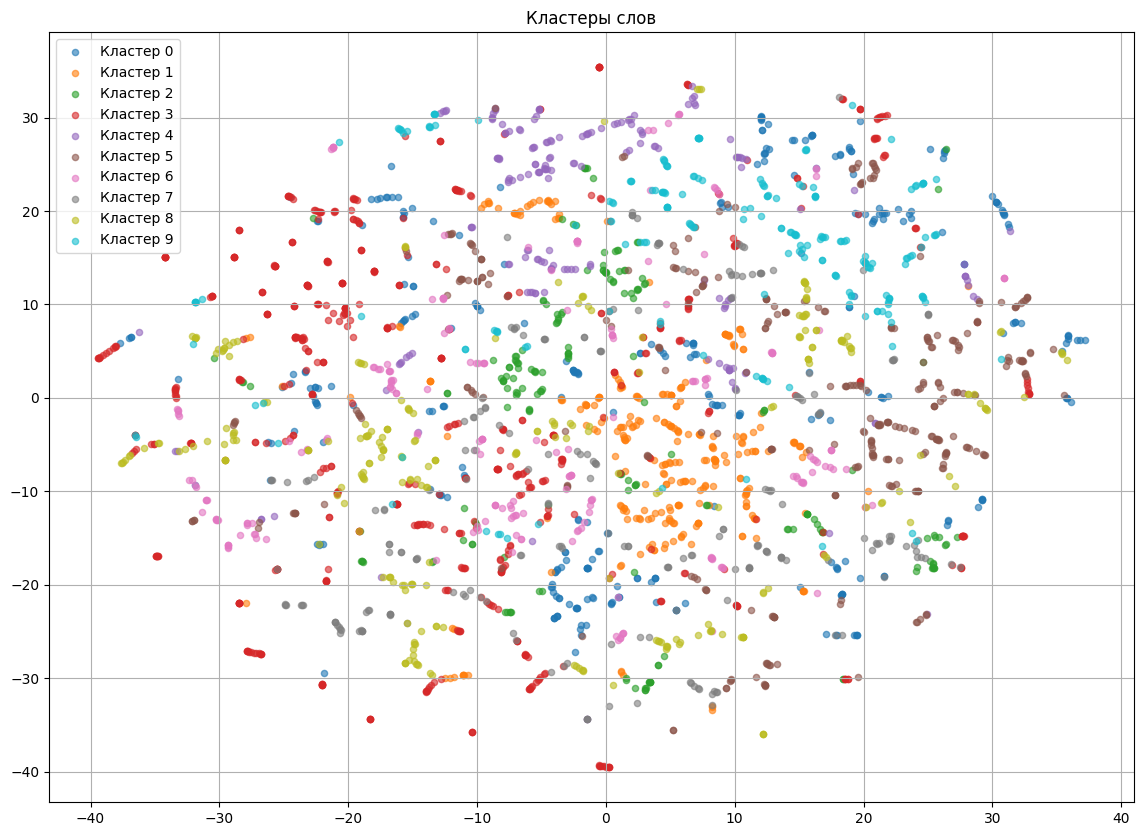

In [52]:
plt.figure(figsize=(14, 10))
for cluster_id in range(NUM_CLUSTERS):
    subset = df_words[df_words["cluster"] == cluster_id]
    plt.scatter(subset["x"], subset["y"], label=f"Кластер {cluster_id}", alpha=0.6, s=20)
plt.title("Кластеры слов")
plt.legend()
plt.grid(True)
plt.show()

Визуализация подтверждает, что кластеризация не демонстрирует семантической связности приличного уровня. Некоторые кластеры в целом можно отделить, но тем не менее много сильных пересечений.

Некоторые кластеры все-таки можно интепретировать и использовать, остановлюсь на них и присвою им темы

In [53]:
for i in range(NUM_CLUSTERS):
    print(f"\nКластер {i}:")
    print(df_words[df_words["cluster"] == i]["word"].head(20).to_list())


Кластер 0:
['työ', 'tapahtuma', 'heinävaara', 'joensuu', 'toiminta', 'avoin', 'yhteinen', 'heinäkuu', 'järjestäminen', 'kyläturvallisuus', 'hanke', 'motto', 'toimia', 'hävitä', 'romanttisuus', 'sisänäyttämö', 'heittäytyä', 'lupa', 'turisti', 'tulos']

Кластер 1:
['kilpailu', 'järjestää', 'hankinta', 'peruste', 'suomalainen', 'euro', 'tieto', 'käyttö', 'Suomi', 'laite', 'arvioida', 'sana', 'käyttää', 'pohjoiskarjalainen', 'yritys', 'kotitalous', 'lopulta', 'kysely', 'prosentti', 'hankkia']

Кластер 2:
['vastata', 'silta', 'suunnitelma', 'muutos', 'tiedote', 'vaatia', 'suvantosilta', 'toteutua', 'henkilö', 'alkukesä', 'itäsilta', 'tehtävä', 'vesi', 'etelä', 'rautatieasema', 'enintään', 'viikko', 'puoleinen', 'suunnitella', 'henkilöstö']

Кластер 3:
['käsi', 'kulkea', 'rohkea', 'innovatiivinen', 'toiminnallinen', 'rakentaminen', 'ilo', 'palkintotiedote', 'kuva', 'esimerkki', 'asuinpaikka', 'vetovoimainen', 'perustelu', 'ihailtava', 'sinnikkyys', 'ehdokas', 'sekaisin', 'menitä', 'viiru', 

In [54]:
cluster_labels = {
    0: "Yhteiskunta ja elämä (Общество и повседневная жизнь)",
    1: "Rikokset ja organisaatiot (Преступления и организации)",
    2: "Arkipäivät (Повседневность)",
    3: "Media ja julkaisut (Медиа и публикации)",
    5: "Paikat ja liikkuminen (Места и передвижение)",
    7: "Geopolitiikka ja kansainväliset suhteet (Геополитика и международные отношения)",
    8: "Talous (Экономика)",
    9: "Politiikka (Политика)"
}

df_words["theme"] = df_words["cluster"].map(cluster_labels)
df_words.to_csv(CLUSTERED_PATH, index=False)
print(f"Кластеризованные слова сохранены в: {CLUSTERED_PATH}")

Кластеризованные слова сохранены в: clustered_words_with_themes.csv


## 5. Извлечение пар глагол + объект

In [55]:
#преобразую строку в список словарей
df["syntax_info"] = df["syntax_info"].apply(ast.literal_eval)

In [56]:
#извлекаю пары (глагол + объект): ищу существительные с функцией obj и проверяю, что их главное слово это глагол
def extract_verb_object_pairs_from_syntax(syntax_data):
    pairs = []
    words = {word["id"]: word for word in syntax_data}

    for word in syntax_data:
        if word["deprel"] == "obj" and word["upos"] == "NOUN":
            head = words.get(word["head"])
            if head and head["upos"] == "VERB":
                pairs.append((head["lemma"], word["lemma"]))
    return pairs

all_pairs = []

for syntax in df["syntax_info"]:
    all_pairs.extend(extract_verb_object_pairs_from_syntax(syntax))

#считаю частотность
pair_counter = Counter(all_pairs)

#визуализация топ-20 самых частотных
for (verb, noun), freq in pair_counter.most_common(20):
    print(f"{verb} + {noun}  ({freq} раз)")

tehdä + työ  (2826 раз)
rakentaa + tulevaisuus  (1706 раз)
kulkea + kuva  (1632 раз)
tehdä + motto  (1521 раз)
vahvistaa + sarkkinen  (1441 раз)
kuvata + kovero  (1410 раз)
katsoa + varkaus  (1362 раз)
säestää + sarkkinen  (1239 раз)
valita + pohjoiskarjala  (1123 раз)
nostaa + toiminta  (1011 раз)
lisätä + tunnettavuus  (1011 раз)
palkita + kylä  (904 раз)
saapia + kunniamaininta  (892 раз)
hakea + toimiala  (100 раз)
haudata + luu  (96 раз)
tehdä + näytelmä  (90 раз)
ottaa + ripittäytyminen  (85 раз)
hakea + sana  (85 раз)
viedä + näytelmä  (84 раз)
käynnistää + muutosneuvottelu  (77 раз)


In [57]:
df_pairs = pd.DataFrame(pair_counter.items(), columns=["pair", "count"])
df_pairs[["verb", "noun"]] = pd.DataFrame(df_pairs["pair"].tolist(), index=df_pairs.index)
df_pairs = df_pairs.drop(columns=["pair"])
df_pairs = df_pairs.sort_values(by="count", ascending=False)

df_pairs.to_csv("verb_noun_pairs.csv", index=False)

## 6. Тематическое моделирование

Выбираю BERTopic, он хорошо подходит для короткий текстов + он хорошо справляется с финским.

In [58]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

In [59]:
df = pd.read_csv("filtered_corpus.csv")

#убираю пустые строки
texts = df["cleaned_text"].dropna().tolist()

#оставляю только предложения, где больше 3 лемм
texts = [t for t in texts if len(t.split()) > 3]

#подгружаю многоязычную модель эмбеддингов
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

#инициализирую модель
topic_model = BERTopic(embedding_model=embedding_model)

#обучение модели на тексте + сохранение вероятностей
topics, probs = topic_model.fit_transform(texts)

print(topic_model.get_topic_info().head(10))

print(topic_model.get_topic(0))

#сохраняю модель
topic_model.save("bertopic_model_finnish")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-07-12 09:22:30,921 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


   Topic  Count                                               Name  \
0     -1     80       -1_hurmaava_iltaristeily_näky_henkeäsalpaava   
1      0   1706  0_valintaperustelu_toiminnallinen_rohkea_tarmokas   
2      1   1632                    1_käsi_kuva_palkintotiedote_ilo   
3      2   1528            2_yhteisö_ilmapiiri_positiivinen_asenne   
4      3   1521        3_motto_kyläturvallisuus_hanke_kehittäminen   
5      4   1441                4_kuvailla_vahvistaa_emma_sarkkinen   
6      5   1410  5_kunniamaininnatkilpailu_ansiokas_pitkäjännei...   
7      6   1376  6_vetovoimainen_sinnikkyys_määrätietoinen_peru...   
8      7   1362                  7_varkaus_sallia_hauata_vesitorni   
9      8   1360  8_maarianvaara_kesäkiertue_sisänäyttämö_nuoris...   

                                      Representation  \
0  [hurmaava, iltaristeily, näky, henkeäsalpaava,...   
1  [valintaperustelu, toiminnallinen, rohkea, tar...   
2  [käsi, kuva, palkintotiedote, ilo, rakentamine...   
3  [y

In [61]:
topic_labels = {
    0: "Туризм и приключения",
    1: "Экономика и финансы",
    2: "Инновации и технологии",
    3: "Образование и личностное развитие",
    4: "Социальная активность и вовлеченность",
    5: "Культура и искусство",
    6: "Городская жизнь и инфраструктура",
    7: "Социальное развитие и сотрудничество",
    8: "Экологическая устойчивость и природоохранные мероприятия",
    9: "Географические особенности и местные сообщества"
}

In [62]:
topic_info = topic_model.get_topic_info()
topic_info["theme"] = topic_info["Topic"].map(topic_labels)
topic_info.to_csv("bertopic_themes_labeled.csv", index=False)

In [65]:
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs,theme
0,-1,80,-1_hurmaava_iltaristeily_näky_henkeäsalpaava,"[hurmaava, iltaristeily, näky, henkeäsalpaava,...",[iltaristeily kaunis auringonlasku suorastaan ...,NaN
1,0,1706,0_valintaperustelu_toiminnallinen_rohkea_tarmokas,"[valintaperustelu, toiminnallinen, rohkea, tar...",[heinävaara innovatiivinen toiminnallinen tarm...,Туризм и приключения
2,1,1632,1_käsi_kuva_palkintotiedote_ilo,"[käsi, kuva, palkintotiedote, ilo, rakentamine...",[kovero kylä yhteisöllisyys tekeminen ilo tule...,Экономика и финансы
3,2,1528,2_yhteisö_ilmapiiri_positiivinen_asenne,"[yhteisö, ilmapiiri, positiivinen, asenne, käy...",[yhteisö positiivinen ilmapiiri käytännönlähei...,Инновации и технологии
4,3,1521,3_motto_kyläturvallisuus_hanke_kehittäminen,"[motto, kyläturvallisuus, hanke, kehittäminen,...",[kylä motto kylä näkyä hanke tapahtuma järjest...,Образование и личностное развитие


Немного выводов по результатам: большинство тем в целом интепретируемы, темы разнообразны, некоторые темы пересекаются. Есть нейтральные темы, сложные для тематического моделирования, но BERTopic показывает значительное преимущество перед кластеризацией

Решила посмотреть на результаты, которые сможет дать LDA:

In [63]:
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from pprint import pprint

texts = [text.split() for text in df["cleaned_text"].dropna()]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=10,
    random_state=42
)

pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.492*"heinävaara" + 0.205*"joensuu" + 0.100*"tapahtua" + 0.064*"taso" + '
  '0.004*"vastata" + 0.004*"kesäkuu" + 0.003*"sisätila" + 0.002*"kihaus" + '
  '0.002*"viedä" + 0.002*"täynnä"'),
 (1,
  '0.545*"kylä" + 0.264*"kovero" + 0.067*"värtsilä" + 0.057*"syntyä" + '
  '0.027*"kunniamaininta" + 0.013*"tohmajärvi" + 0.011*"tunti" + '
  '0.001*"liikenne" + 0.001*"erilainen" + 0.001*"alku"'),
 (2,
  '0.077*"kylätoiminta" + 0.077*"toiminta" + 0.056*"alue" + 0.056*"kyläläinen" '
  '+ 0.055*"ansiokas" + 0.055*"pitkäjänneinen" + '
  '0.055*"kunniamaininnatkilpailu" + 0.041*"saavuttaa" + 0.041*"asuinpaikka" + '
  '0.041*"sinnikkyys"'),
 (3,
  '0.290*"tulevaisuus" + 0.078*"todeta" + 0.078*"rakentaa" + '
  '0.078*"toiminnallinen" + 0.078*"tarmokas" + 0.078*"innovatiivinen" + '
  '0.078*"rohkea" + 0.078*"valintaperustelu" + 0.028*"katsoa" + '
  '0.013*"elinvoimainen"'),
 (4,
  '0.200*"maarianvaara" + 0.122*"maakunta" + 0.098*"nuorisoseurantalo" + '
  '0.097*"kesäkiertue" + 0.097*"sisänäytt

Тут интепретируемость LDA вызывает вопросы, все темы получились смешанными, бытовыми, нейтральными, без явного семантического поля

TF-IDF

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [67]:
df = pd.read_csv("filtered_corpus.csv")
df = df.dropna(subset=["cleaned_text", "pos_sequence"])

In [68]:
#беру только основные части речи, слежубные очищаю
allowed_pos = {"NOUN", "VERB", "ADJ", "ADV"}
filtered_docs = []

for lemmas, pos_tags in zip(df["cleaned_text"], df["pos_sequence"]):
    words = lemmas.split()
    pos = pos_tags.split()
    filtered_words = [w for w, p in zip(words, pos) if p in allowed_pos]
    filtered_docs.append(" ".join(filtered_words))

In [69]:
#создаю TF-IDF векторизатор
vectorizer = TfidfVectorizer()
#делаю матрицу
tfidf_matrix = vectorizer.fit_transform(filtered_docs)
#извлекаю список слов
feature_names = vectorizer.get_feature_names_out()
#суммирую TF-IDF для каждого слова
word_scores = tfidf_matrix.sum(axis=0).A1
#сопоставляю слова и их итоговые TF-IDF значения
tfidf_scores = dict(zip(feature_names, word_scores))

#выбираю 100 слов с самым высоким значением
top_n = 100
top_keywords = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
top_words_set = set(word for word, _ in top_keywords)

print(f"\nТоп слов по TF-IDF:")
for word, score in top_keywords:
    print(f"{word:<20} {score:.4f}")


Топ слов по TF-IDF:
kylä                 3296.9616
kovero               1471.9122
sarkkinen            1441.6187
ehdokas              1351.0000
pohjoiskarjala       1317.4271
maakuntaliitto       1154.8113
näkyä                1112.3214
käsi                 1043.1140
heinävaara           1024.6032
tapahtuma            997.0382
hävitä               987.8282
romanttisuus         987.8282
lähteä               968.0706
varkaus              964.7450
säestää              951.4955
joensuu              950.5795
matka                922.5833
värtsilä             918.3796
yhteisöllisyys       860.7140
vahvistaa            753.8051
emma                 751.5885
heittäytyä           749.9923
mahlamä              749.3161
kuvailla             747.6125
huomauttaa           746.0899
ansiokas             679.8247
kunniamaininnatkilpailu 679.8247
pitkäjänneinen       679.8247
monipuolinen         666.8342
arki                 649.3617
asenne               643.4785
ilmapiiri            643.4785
positii

Сравнение

In [70]:
#с BERT
df_topics = topic_model.get_topic_info()
bertopic_top_words = {}

for topic_id in df_topics.Topic[:10]:
    if topic_id == -1:
        continue
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    bertopic_top_words[topic_id] = words

In [71]:
# Сравнение
for topic_id, words in bertopic_top_words.items():
    intersection = set(words) & top_words_set
    print(f"\nТема {topic_id}:")
    print("Слова из BERTopic:", ", ".join(words))
    print("Совпадают с TF-IDF:", ", ".join(intersection) if intersection else "—")


Тема 0:
Слова из BERTopic: valintaperustelu, toiminnallinen, rohkea, tarmokas, innovatiivinen, rakentaa, yhteinen, todeta, syntyä, heinävaara
Совпадают с TF-IDF: toiminnallinen, todeta, syntyä, heinävaara, yhteinen, tarmokas, rakentaa, valintaperustelu, rohkea

Тема 1:
Слова из BERTopic: käsi, kuva, palkintotiedote, ilo, rakentaminen, kulkea, yhteisöllisyys, tekeminen, tulevaisuus, kovero
Совпадают с TF-IDF: käsi, kuva, rakentaminen, tulevaisuus, tekeminen, kovero, ilo, yhteisöllisyys, palkintotiedote

Тема 2:
Слова из BERTopic: yhteisö, ilmapiiri, positiivinen, asenne, käytännönläheinen, arki, näkyä, , , 
Совпадают с TF-IDF: näkyä, asenne, arki, ilmapiiri, yhteisö, positiivinen

Тема 3:
Слова из BERTopic: motto, kyläturvallisuus, hanke, kehittäminen, järjestäminen, tapahtuma, näkyä, kylä, , 
Совпадают с TF-IDF: näkyä, hanke, tapahtuma, kylä, kehittäminen, järjestäminen, motto

Тема 4:
Слова из BERTopic: kuvailla, vahvistaa, emma, sarkkinen, , , , , , 
Совпадают с TF-IDF: emma, vahvis

In [72]:
#с LDA
for i in range(10):
    topic_terms = lda_model.show_topic(i, topn=10)
    topic_words = [word for word, _ in topic_terms]
    overlap = top_words_set.intersection(topic_words)
    overlap_pct = 100 * len(overlap) / len(topic_words)

    print(f"\nТема {i}:")
    print("Топ-слова темы:", ", ".join(topic_words))
    print(f"Совпадающих с TF-IDF: {len(overlap)} ({overlap_pct:.1f}%)")
    if overlap:
        print("Совпадающие слова:", ", ".join(overlap))


Тема 0:
Топ-слова темы: heinävaara, joensuu, tapahtua, taso, vastata, kesäkuu, sisätila, kihaus, viedä, täynnä
Совпадающих с TF-IDF: 3 (30.0%)
Совпадающие слова: joensuu, tapahtua, heinävaara

Тема 1:
Топ-слова темы: kylä, kovero, värtsilä, syntyä, kunniamaininta, tohmajärvi, tunti, liikenne, erilainen, alku
Совпадающих с TF-IDF: 6 (60.0%)
Совпадающие слова: värtsilä, syntyä, kylä, kovero, kunniamaininta, tohmajärvi

Тема 2:
Топ-слова темы: kylätoiminta, toiminta, alue, kyläläinen, ansiokas, pitkäjänneinen, kunniamaininnatkilpailu, saavuttaa, asuinpaikka, sinnikkyys
Совпадающих с TF-IDF: 7 (70.0%)
Совпадающие слова: saavuttaa, sinnikkyys, kylätoiminta, ansiokas, pitkäjänneinen, kunniamaininnatkilpailu, toiminta

Тема 3:
Топ-слова темы: tulevaisuus, todeta, rakentaa, toiminnallinen, tarmokas, innovatiivinen, rohkea, valintaperustelu, katsoa, elinvoimainen
Совпадающих с TF-IDF: 8 (80.0%)
Совпадающие слова: todeta, toiminnallinen, tulevaisuus, katsoa, tarmokas, rakentaa, valintaperustelu

Модель LDA показала себя лучше с точки зрения интерпретируемости тем: в среднем 70% слов из каждой темы совпадают с наиболее значимыми по TF-IDF, что говорит о её способности выделять частотные группы. Темы LDA интуитивно понятны: повседневная жизнь, семья, работа, эмоции и действия.

В то же время BERTopic выдал менее совпадающие с TF-IDF темы (около 30–40%). Тем не менее, он лучше справляется с узкими нишами и может быть полезен для поиска специфических кластеров, лексики по темам.

Таким образом, LDA более надёжен для лексико-грамматической базы упражнений, особенно на уровне A1–B1, а BERTopic можно использовать как дополнение, например, при создании упражнений на тематическую лексику, особенно для продвинутых учащихся.

Но в данном проекте у меня разделения на уровни нет, поэтому это просто выводы на будущее.

## Упражнение 1 - Выбери правильное пропущенное слово

Это упражнение реализует задание на вставку пропущенного слова с вариантами ответа (multiple-choice gap-filling), ориентированное на лексическую тренировку.

Как работает:

-- Из корпуса выбирается случайное предложение.

-- В нем случайным образом выбирается одно слово

-- Это слово заменяется на пропуск (____)

-- К нему подбираются 3 дистрактора (неправильные, но похожие по форме и части речи слова) с помощью word2vec

-- Пользователю предлагается выбрать правильный вариант из 4.

После ответа:

если верно — выводится подтверждение,

если неверно — предлагается попробовать снова (пока не угадает).

In [73]:
df = pd.read_csv("filtered_corpus.csv").dropna(subset=["text", "lemmatized_text", "pos_sequence"])

sentences = df["text"].tolist()
lemmatized_texts = df["lemmatized_text"].tolist()
pos_sequences = df["pos_sequence"].tolist()
syntax_infos = df['syntax_info'].tolist()
original_texts = df['text'].tolist()

In [74]:
def generate_multiple_choice_with_morphology(sentence, lemmatized, pos_seq, syntax_info, model, original_sentence, num_choices=4):

    words = sentence.split()
    lemmas = lemmatized.split()
    pos_tags = pos_seq.split()
    syntax = ast.literal_eval(syntax_info)
    original_words = original_sentence.split()

    # беру только наиболее значимые и проблемные части речи
    valid_pos = {"NOUN", "VERB", "ADJ", "ADV"}

    # ищу слова, которые подходят по параметрам
    candidates = [
        (i, w) for i, w in enumerate(syntax)
        if w["upos"] in valid_pos and w["lemma"] in model.wv
    ]

    if not candidates:
        return None

    # случайным образом выбираю слово, которое будет пропущено
    target_index, target_info = random.choice(candidates)
    target_lemma = target_info["lemma"]
    target_pos = target_info["upos"]
    target_feats = target_info.get("feats", "")
    target_form = words[target_index]

    # ищу похожие леммы в векторном пространстве
    similar = model.wv.most_similar(target_lemma, topn=100)

    # мне нужно, чтобы дистракторы были той же части речи и стояли в такой же форме
    distractors = []
    for word, _ in similar:
        for w in syntax:
            if (
                w["lemma"] == word
                and w["upos"] == target_pos
                and w.get("feats", "") == target_feats
                and w["text"] != target_form
            ):
                distractors.append(w["text"])
                break
        if len(distractors) >= num_choices - 1:
            break

    if len(distractors) < num_choices - 1:
        return None

    choices = distractors + [target_form]
    random.shuffle(choices)

    # маскируем оригинальное предложение
    masked = original_words[:target_index] + ['____'] + original_words[target_index + 1:]
    masked_sentence = " ".join(masked)

    return {
        "sentence": masked_sentence,
        "answer": target_form,
        "choices": choices,
        "original": original_sentence
    }

In [75]:
def interactive_multiple_choice(sentences, lemmatized_texts, pos_sequences, syntax_infos, original_texts, model):
    print("Упражнение 1: Выбери пропущенное слово (укажи цифру). Напиши 'конец' для выхода.\n")

    while True:
        idx = random.randint(0, len(sentences) - 1)
        sentence = sentences[idx]
        lemmatized = lemmatized_texts[idx]
        pos_seq = pos_sequences[idx]
        syntax_info = syntax_infos[idx]
        original_sentence = original_texts[idx]

        result = generate_multiple_choice_with_morphology(sentence, lemmatized, pos_seq, syntax_info, model, original_sentence)

        if not result:
            continue  # если не удалось сгенерировать задание, берём следующую строку

        print(f"Предложение с пропущенным словом: {result['sentence']}")
        for i, choice in enumerate(result['choices']):
            print(f"{i + 1}) {choice}")

        while True:
            user = input("Выбери номер ответа (или напиши 'конец'): ").strip()
            if user.lower() == "конец":
                print("Упражнение завершено.")
                return
            if not user.isdigit() or not (1 <= int(user) <= len(result["choices"])):
                print("Неверный ввод. Укажи цифру.")
                continue

            choice = result["choices"][int(user) - 1]
            if choice == result["answer"]:
                print("Верно!")
                break
            else:
                print("Неверно. Попробуй еще раз.\n")
                second_try = input("Выбери еще раз: ").strip()
                if second_try.lower() == "конец":
                    print("Упражнение завершено.")
                    return
                if (
                    second_try.isdigit()
                    and 1 <= int(second_try) <= len(result["choices"])
                    and result["choices"][int(second_try) - 1] == result["answer"]
                ):
                    print("Верно со второй попытки!")
                else:
                    print(f"Неправильно. Правильный ответ: {result['answer']}")
                break

In [76]:
interactive_multiple_choice(sentences, lemmatized_texts, pos_sequences, syntax_infos, original_texts, w2v_model)

Упражнение 1: Выбери пропущенное слово (укажи цифру). Напиши 'конец' для выхода.

Предложение с пропущенным словом: kovero on ____ jossa yhteisöllisyys tekemisen ilo ja tulevaisuuden rakentaminen kulkevat käsi kädessä palkintotiedote kuvaa
1) palkintotiedote
2) kylä
3) kovero
4) käsi
Выбери номер ответа (или напиши 'конец'): 2
Верно!
Предложение с пропущенным словом: kovero on kylä jossa yhteisöllisyys tekemisen ilo ja tulevaisuuden rakentaminen kulkevat käsi kädessä ____ kuvaa
1) ilo
2) käsi
3) yhteisöllisyys
4) palkintotiedote
Выбери номер ответа (или напиши 'конец'): 3
Неверно. Попробуй еще раз.

Выбери еще раз: 2
Неправильно. Правильный ответ: palkintotiedote
Предложение с пропущенным словом: ____ on kylä jossa yhteisöllisyys tekemisen ilo ja tulevaisuuden rakentaminen kulkevat käsi kädessä palkintotiedote kuvaa
1) palkintotiedote
2) käsi
3) kovero
4) ilo
Выбери номер ответа (или напиши 'конец'): 3
Верно!
Предложение с пропущенным словом: kovero on kylä jossa ____ tekemisen ilo ja 

## Упражнение 2. Определи грамматическую форму слова

Это упражнение направлено на развитие морфологического анализа. Учащемуся предлагается определить часть речи и грамматические признаки заданного слова в контексте предложения.

Как работает:

-- Из корпуса выбирается случайное предложение с синтаксическим разбором
-- В нем случайным образом выбирается слово
-- Это слово показывается пользователю вместе с полным предложением
-- Пользователю предлагается ввести:

Часть речи и грамматические признаки

In [77]:
df = pd.read_csv("filtered_corpus.csv")

df = df.dropna(subset=["syntax_info"])

#преобразуем строку в список словарей
df["syntax_info"] = df["syntax_info"].apply(ast.literal_eval)

#выбираю случайное слово из предложения
def generate_form_recognition_from_syntax(syntax_data):

    valid_upos = {"NOUN", "VERB", "ADJ", "ADV", "NUM"}
    words = [w for w in syntax_data if w["upos"] in valid_upos]
    if len(words) < 4:
        return None

    target = random.choice(words)
    sentence = " ".join([w["text"] for w in syntax_data])

    return {
        "sentence": sentence,
        "word": target["text"],
        "lemma": target["lemma"],
        "upos": target["upos"],
        "feats": target["feats"] if target.get("feats") else "No features"
    }

def interactive_form_recognition(syntax_list):
    print("Упражнение 2: Определи грамматическую форму слова.\nНапиши 'конец' для выхода.\n")

    i = 0
    while i < len(syntax_list):
        result = generate_form_recognition_from_syntax(syntax_list[i])
        i += 1
        if not result:
            continue

        print(f"Слово: {result['word']}")

        user_upos = input("Часть речи (например, NOUN, VERB, ADJ): ").strip().upper()
        if user_upos.lower() == "конец":
            print("Упражнение завершено.")
            break

        if user_upos != result["upos"]:
            retry = input("Неверно. Хочешь попробовать ещё раз? (да/нет): ").strip().lower()
            if retry == "да":
                user_upos = input("Попробуй ещё раз: ").strip().upper()

        user_feats = input("Морфологические признаки (например, Case=Nom): ").strip()

        print("\nПравильный ответ:")
        print(f"Лемма: {result['lemma']}")
        print(f"Часть речи: {result['upos']}")
        print(f"Признаки: {result['feats']}")

        print("\nВаш ответ:")
        if user_upos == result["upos"]:
            print("Часть речи: правильно!")
        else:
            print("Часть речи: неправильно.")

        feats_gold = result["feats"] or ""
        if user_feats and user_feats.lower() in feats_gold.lower():
            print("Признаки: частично/полностью совпадают!")
        else:
            print("Признаки: не совпадают.")

In [78]:
interactive_form_recognition(df["syntax_info"].tolist())

Упражнение 2: Определи грамматическую форму слова.
Напиши 'конец' для выхода.

Слово: suunniteltuja
Часть речи (например, NOUN, VERB, ADJ): verb
Морфологические признаки (например, Case=Nom): part

Правильный ответ:
Лемма: suunnitella
Часть речи: VERB
Признаки: Case=Par|Number=Plur|PartForm=Past|VerbForm=Part|Voice=Pass

Ваш ответ:
Часть речи: правильно!
Признаки: частично/полностью совпадают!
Слово: selvittänyt
Часть речи (например, NOUN, VERB, ADJ): конец
Упражнение завершено.


## Упражнение 3. Поставь слово в нужную форму

Это упражнение направлено на тренировку словоизменения (спряжения и склонения).

Пользователь получает начальную форму и грамматические признаки, и он должен написать слово в нужной форме (она сравнивается с формой из корпуса).

Как работает:
-- Из корпуса выбирается случайное предложение (минимум 4 слова).

-- В предложении выбирается слово с грамматической информацией (часть речи, грамматические признаки).

Учащийся видит:

всё предложение, начальную форму слова и набор грамматических признаков;

Он вводит ответ.

In [79]:
#словарик для перевода сокращений в привычные термины
FEATURE_TRANSLATIONS = {
    "Case": {
        "Nom": "номинатив",
        "Gen": "генитив",
        "Par": "партитив",
        "Ine": "инессив",
        "Ela": "элатив",
        "Ill": "иллатив",
        "Ade": "адессив",
        "Abl": "аблатив",
        "All": "аллатив",
        "Tra": "транслатив",
        "Ess": "эссив",
        "Abe": "абессив"
    },
    "Number": {
        "Sing": "единственное число",
        "Plur": "множественное число"
    },
    "Mood": {
        "Ind": "изъявительное наклонение",
        "Imp": "повелительное наклонение",
        "Pot": "потенциальное наклонение",
        "Cnd": "условное наклонение"
    },
    "Tense": {
        "Pres": "настоящее время",
        "Past": "прошедшее время"
    },
    "Person": {
        "1": "1 лицо",
        "2": "2 лицо",
        "3": "3 лицо"
    },
    "Voice": {
        "Act": "действительный залог",
        "Pass": "страдательный залог"
    },
    "VerbForm": {
        "Fin": "личная форма",
        "Inf": "инфинитив",
        "Part": "причастие"
    },
    "Degree": {
        "Pos": "положительная степень",
        "Cmp": "сравнительная степень",
        "Sup": "превосходная степень"
    }
}

In [80]:
#перевожу признаки в привычные русские термины
def translate_features(feats):
    if not feats or pd.isna(feats):
        return "Без признаков"

    result = []
    for item in feats.split("|"):
        if "=" in item:
            key, value = item.split("=")
            translation = FEATURE_TRANSLATIONS.get(key, {}).get(value)
            result.append(translation if translation else f"{key}={value}")
        else:
            result.append(item)
    return ", ".join(result)

In [81]:
#извлекает предложение и "целевое" слово с грамматическими признаками, в предложении должно быть хотя бы 3 слова
def generate_inflection(syntax_data):
    words = [w for w in syntax_data if w["upos"] != "PUNCT" and w.get("feats")]
    if len(words) < 3:
        return None

    target = random.choice(words)
    sentence = " ".join(w["text"] for w in syntax_data)

    return {
        "sentence": sentence,
        "lemma": target["lemma"],
        "target_form": target["text"],
        "features": target["feats"]
    }

def interactive_inflection_task(syntax_list):
    print("Упражнение 3: Поставь слово в нужную форму.")
    print("Чтобы закончить, напиши 'конец'.\n")

    i = 0
    while i < len(syntax_list):
        result = generate_inflection(syntax_list[i])
        i += 1

        if not result:
            continue

        print(f"Начальная форма: {result['lemma']}")
        print(f"Требуемая форма: {translate_features(result['features'])}")

        correct = result["target_form"].lower()

        while True:
            user_input = input("Твой ответ: ").strip().lower()

            if user_input == "конец":
                print("Упражнение завершено.")
                return
            elif user_input == "пропустить":
                print(f"Пропущено. Правильный ответ: {correct}\n")
                break
            elif user_input == correct:
                print("Верно! Молодец!\n")
                break
            else:
                print("Неверно. Попробуй ещё раз или напиши 'пропустить'.")

In [82]:
interactive_inflection_task(df["syntax_info"].tolist())

Упражнение 3: Поставь слово в нужную форму.
Чтобы закончить, напиши 'конец'.

Начальная форма: selvittää
Требуемая форма: номинатив, единственное число, PartForm=Past, причастие, действительный залог
Твой ответ: selvittynyt
Неверно. Попробуй ещё раз или напиши 'пропустить'.
Твой ответ: selvitetty
Неверно. Попробуй ещё раз или напиши 'пропустить'.
Твой ответ: selvitettynyt
Неверно. Попробуй ещё раз или напиши 'пропустить'.
Твой ответ: пропустить
Пропущено. Правильный ответ: selvittänyt

Начальная форма: kesäloma
Требуемая форма: адессив, единственное число
Твой ответ: kesälomalla
Верно! Молодец!

Начальная форма: suunnitella
Требуемая форма: партитив, множественное число, PartForm=Past, причастие, страдательный залог
Твой ответ: конец
Упражнение завершено.


## Упражнение 4. Найди и исправь ошибку в предложении

Мы берём настоящее предложение и искусственно заменяем одно слово (например, глагол или существительное) на случайное слово того же типа, но из другого контекста.
задача ученика — найти и исправить её.

Ошибка может быть двух типов: "лексическая", т.е. подмена слова, и грамматическая, т.е. то же слово, но в другой форме

In [83]:
from collections import defaultdict

syntax_info_docs = df["syntax_info"].tolist()

def build_pos_dictionary(syntax_info_docs, target_upos=("NOUN", "VERB", "ADJ", "ADV")):
    pos_dict = defaultdict(list)
    for sentence in syntax_info_docs:
        for word in sentence:
            if word["upos"] in target_upos and word["text"].isalpha():
                pos_dict[word["upos"]].append(word["text"])
    return pos_dict

pos_dict = build_pos_dictionary(syntax_info_docs)

def corrupt_sentence_mixed(syntax_doc, pos_dict):
    if len(syntax_doc) < 4:
        return None

    sentence_text = " ".join([w["text"] for w in syntax_doc])
    candidates = [w for w in syntax_doc if w["upos"] in pos_dict and w.get("feats") and w["text"].isalpha()]
    if not candidates:
        return None

    #случайным образом выбираем слово для замены
    target = random.choice(candidates)
    original_word = target["text"]
    upos = target["upos"]

    #выбираем случайным образом тип ошибки: лексическую или грамматическую
    corruption_type = random.choice(["lexical", "grammatical"])

    #если лексическая ошибка: подбираем слово той же части речи
    if corruption_type == "lexical":
        replacement_candidates = [w for w in pos_dict[upos] if w.lower() != original_word.lower()]
        if not replacement_candidates:
            return None
        wrong_word = random.choice(replacement_candidates)
    else:
        #если грамматическая ошибка: ищем подходящую форму этого слова
        lemma = target["lemma"]
        all_forms = [w for w in pos_dict[upos] if w.lower() != original_word.lower() and lemma.lower() in w.lower()]
        if all_forms:
            wrong_word = random.choice(all_forms)
        else:
            return None

    corrupted = sentence_text.replace(original_word, wrong_word, 1)

    return {
        "original": sentence_text,
        "corrupted": corrupted,
        "expected_word": original_word,
        "wrong_word": wrong_word,
        "upos": upos,
        "type": corruption_type
    }

def interactive_find_error(syntax_info_docs, pos_dict):
    print("Упражнение 4: Найди и исправь ошибку в предложении.")
    print("Напиши 'конец' для выхода.\n")

    while True:
        syntax_doc = random.choice(syntax_info_docs)
        result = corrupt_sentence_mixed(syntax_doc, pos_dict)

        if not result:
            continue

        print(f"\nПредложение: {result['corrupted']}")
        user = input("Введи ПРАВИЛЬНУЮ (уже исправленную) форму слова: ").strip()

        if user.lower() == "конец":
            print("Упражнение завершено")
            break

        if user.lower() == result["expected_word"].lower():
            print("Верно!")
        else:
            print(f"Неверно. Правильный ответ: {result['expected_word']}")

In [86]:
interactive_find_error(syntax_info_docs, pos_dict)

Упражнение 4: Найди и исправь ошибку в предложении.
Напиши 'конец' для выхода.


Предложение: yhteisön positiivinen ilmapiiri ja käytännönläheinen asenne näkyvät arjessa tehdä yhdessä ja tehdään hyvin
Введи ПРАВИЛЬНУЮ (уже исправленную) форму слова: tekemään
Неверно. Правильный ответ: tehdään

Предложение: koverossa toimii aktiivisia tekijöitä joiden työn tuloksena kylällä on monipuolista toimintaa ja ryhmäläisellä
Введи ПРАВИЛЬНУЮ (уже исправленную) форму слова: конец
Упражнение завершено


## Упражнение 5. Найди лишнее слово

Пользователь видит 4-5 слов, из которых одно не относится к теме совсем, а остальные - из одного кластера. Задача пользователя правильно определить лишнее слово.

In [87]:
topic_info = topic_model.get_topic_info()
topic_words = {
    topic_id: [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    for topic_id in topic_info.Topic if topic_id != -1
}

In [88]:
import random

def generate_find_odd_word_exercise(topic_words):
    #выбираю случайную тему
    main_topic = random.choice(list(topic_words.keys()))
    main_words = topic_words[main_topic]

    if len(main_words) < 3:
        return None

    #выбираю из темы 3-4 слова
    chosen_main_words = random.sample(main_words, min(4, len(main_words)))

    #выбираю другую тему для "лишнего" слова
    other_topics = [t for t in topic_words.keys() if t != main_topic]
    odd_topic = random.choice(other_topics)
    odd_word_candidates = topic_words[odd_topic]

    #из нее выбираю одно слово
    odd_word = random.choice(odd_word_candidates)

    #делаю список вариантов и перемешиваю
    options = chosen_main_words + [odd_word]
    random.shuffle(options)

    return {
        "options": options,
        "odd_word": odd_word,
        "theme": main_topic
    }

In [89]:
def interactive_find_odd_word(topic_words):
    print("Упражнение 5: Найди лишнее слово.\nНапиши 'конец' для выхода.\n")

    while True:
        exercise = generate_find_odd_word_exercise(topic_words)
        if not exercise:
            continue

        print("Найди лишнее слово:")
        for i, word in enumerate(exercise["options"], 1):
            print(f"{i}) {word}")

        while True:
            answer = input("Введите номер лишнего слова (или 'конец'): ").strip()
            if answer.lower() == "конец":
                print("Упражнение завершено.")
                return

            if not answer.isdigit() or not (1 <= int(answer) <= len(exercise["options"])):
                print("Неверный ввод. Попробуйте снова.")
                continue

            chosen_word = exercise["options"][int(answer) - 1]

            # Если ответ правильный
            if chosen_word == exercise["odd_word"]:
                print("Верно!\n")
                break  # Выход из цикла, если правильный ответ

            # Если ответ неверный, даем второй шанс
            print("Неверно. Попробуйте снова.")
            # Когда второй раз неверно, выводим правильное слово
            second_try = input("Попробуйте еще раз: ").strip()
            if second_try.lower() == "конец":
                print("Упражнение завершено.")
                return

            if not second_try.isdigit() or not (1 <= int(second_try) <= len(exercise["options"])):
                print("Неверный ввод. Попробуйте снова.")
                continue

            chosen_word_second_try = exercise["options"][int(second_try) - 1]
            if chosen_word_second_try == exercise["odd_word"]:
                print("Верно!\n")
                break  # Выход из второго цикла, если правильный ответ
            else:
                print(f"Неверно. Лишнее слово: {exercise['odd_word']}\n")  # Показываем правильный ответ
                break  # Выход после двух неправильных попыток

In [90]:
interactive_find_odd_word(topic_words)

Упражнение 5: Найди лишнее слово.
Напиши 'конец' для выхода.

Найди лишнее слово:
1) sunnuntai
2) tori
3) 
4) päivä
5) potilas
Введите номер лишнего слова (или 'конец'): 3
Неверно. Попробуйте снова.
Попробуйте еще раз: 5
Верно!

Найди лишнее слово:
1) tuote
2) keijo
3) omantunto
4) taksiautoilija
5) 
Введите номер лишнего слова (или 'конец'): 2
Неверно. Попробуйте снова.
Попробуйте еще раз: 1
Верно!

Найди лишнее слово:
1) yhteistyö
2) oikeutettu
3) käyttää
4) vesi
5) pyrkiä
Введите номер лишнего слова (или 'конец'): конец
Упражнение завершено.


## Упражнение 6. Выбери правильное слово из похожих вариантов

Система подставляет пропущенное слово в предложение. Вместо одного варианта — 3 похожих по написанию слова, одно из которых верное (основано на расстоянии Левенштейна, например: kirja, kirje, kirjaa).

Пользователь должен угадать правильное слово по контексту.

In [91]:
from nltk.metrics.distance import edit_distance

#функция для получения похожих слов на основе расстояния Левенштейна
def get_similar_words(word, vocab, max_distance=1):
    return [w for w in vocab if w != word and edit_distance(word, w) <= max_distance]

#функция для генерации упражнения на основе Левенштейна
def generate_levenshtein_context_exercise(sentences, vocab):
    random.shuffle(sentences)
    for sent in sentences:
        tokens = sent.split()
        for word in tokens:
            word_clean = word.strip(".,!?\"’”“").lower()
            if len(word_clean) < 4 or not word_clean.isalpha():
                continue

            similar = get_similar_words(word_clean, vocab)
            if len(similar) >= 2:
                options = [word_clean] + random.sample(similar, 2)
                random.shuffle(options)
                masked = sent.replace(word, "____", 1)
                return {
                    "sentence": masked,
                    "answer": word_clean,
                    "options": options
                }
    return None

def interactive_similar_word_choice(sentences):
    print("Упражнение 6: Выбери правильное слово из похожих вариантов.")
    print("Для выхода напиши 'конец'.\n")

    vocab = set()
    for sent in sentences:
        for word in sent.split():
            w_clean = word.strip(".,!?\"’”“").lower()
            if w_clean.isalpha() and len(w_clean) >= 4:
                vocab.add(w_clean)

    while True:
        exercise = generate_levenshtein_context_exercise(sentences, vocab)
        if exercise is None:
            print("Не удалось сгенерировать упражнение, попробуй ещё раз.")
            break

        print("\nКонтекст:")
        print(exercise["sentence"])
        print("\nВарианты:")
        for i, opt in enumerate(exercise["options"], 1):
            print(f"  [{i}] {opt}")

        answer = input("Выбери правильное слово (номер или слово): ").strip().lower()

        if answer.lower() == "конец":
            print("Упражнение завершено.")
            break

        if answer.isdigit() and 1 <= int(answer) <= len(exercise["options"]):
            chosen = exercise["options"][int(answer) - 1].lower()
        else:
            chosen = answer

        if chosen == exercise["answer"]:
            print("Верно!")
        else:
            print(f"Неверно. Правильный ответ: {exercise['answer']}")

In [92]:
interactive_similar_word_choice(sentences)

Упражнение 6: Выбери правильное слово из похожих вариантов.
Для выхода напиши 'конец'.


Контекст:
kalenterissani oli tilaa ja idea kuulosti ____ kivalta että laitoin saman tien sähköpostia ja ilmoittauduin mukaan

Варианты:
  [1] näin
  [2] niin
  [3] noin
Выбери правильное слово (номер или слово): 2
Верно!

Контекст:
suvantosillan eteläpään liikennejärjestelyissä on tehty ____ muutos ja alkuperäinen sillan pääty

Варианты:
  [1] uusi
  [2] uusin
  [3] kuusi
Выбери правильное слово (номер или слово): 1
Верно!

Контекст:
katsotaan ____ uusi aika tuo tullessaan

Варианты:
  [1] sitä
  [2] mitä
  [3] mitäs
Выбери правильное слово (номер или слово): конец
Упражнение завершено.


## Упражнение 7. Ректио (глагольное управление)

Система показывает глагол и существительное — пользователь должен написать существительное в нужной грамматической форме.

In [93]:
df_pairs = pd.read_csv("verb_noun_pairs.csv")

df = pd.read_csv("filtered_corpus.csv")
df["syntax_info"] = df["syntax_info"].apply(ast.literal_eval)

def find_sentence_with_pair(df, verb_lemma, noun_lemma):
    for _, row in df.iterrows():
        syntax = row["syntax_info"]
        words = {w["id"]: w for w in syntax}
        for w in syntax:
            if w["deprel"] == "obj" and w["upos"] == "NOUN" and w["lemma"] == noun_lemma:
                head = words.get(w["head"])
                if head and head["upos"] == "VERB" and head["lemma"] == verb_lemma:
                    return row["text"], syntax, w["text"]
    return None, None, None

def interactive_verb_noun_form(df, df_pairs):
    print("Упражнение 7: Напиши существительное в правильной форме после глагола.")
    print("Напиши 'конец' для выхода.\n")

    # Перемешиваем пары для случайного выбора
    pairs_list = df_pairs[["verb", "noun"]].values.tolist()
    random.shuffle(pairs_list)

    for verb_lemma, noun_lemma in pairs_list:
        sentence_text, syntax, correct_form = find_sentence_with_pair(df, verb_lemma, noun_lemma)
        if sentence_text is None:
            continue

        print(f"Глагол (лемма): {verb_lemma}")
        print(f"Существительное (лемма): {noun_lemma}")

        while True:
            user_input = input("Введи правильную форму существительного: ").strip()
            if user_input.lower() == "конец":
                print("Упражнение завершено.")
                return

            if user_input == correct_form:
                print("Верно!\n")
                break
            else:
                print("Неверно. Попробуй ещё раз или напиши 'конец' для выхода.")

In [94]:
interactive_verb_noun_form(df, df_pairs)

Упражнение 7: Напиши существительное в правильной форме после глагола.
Напиши 'конец' для выхода.

Глагол (лемма): saada
Существительное (лемма): äyski
Введи правильную форму существительного: äyskin
Неверно. Попробуй ещё раз или напиши 'конец' для выхода.
Введи правильную форму существительного: äysin
Неверно. Попробуй ещё раз или напиши 'конец' для выхода.
Введи правильную форму существительного: äyski
Неверно. Попробуй ещё раз или напиши 'конец' для выхода.
Введи правильную форму существительного: äyskiä
Верно!

Глагол (лемма): esiintyä
Существительное (лемма): kihaus
Введи правильную форму существительного: конец
Упражнение завершено.


## Упражнение 8. Определитель ключевых слов

Пользователь вводит небольшой финский текст, система лемматизирует его, удаляет стоп-слова, затем с помощью TF-IDF показывает наиболее важные (содержательные) леммы.

In [95]:
def lemmatize_finnish(text):
    text = re.sub(r"[^\w\säöå]", "", text.lower())
    doc = nlp(text)
    lemmas = [
        word.lemma for sent in doc.sentences for word in sent.words
        if word.lemma not in all_stopwords and word.lemma.isalpha()
    ]
    return " ".join(lemmas)

def interactive_tfidf_keywords():
    print("Упражнение 8. Введите финский текст. Программа покажет ключевые слова")
    print("Для выхода напиши 'конец'.\n")

    while True:
        user_text = input("Впишите текст (или 'конец'): ").strip()
        if user_text.lower() in ["конец"]:
            print("Упражнение завершено.")
            break

        lemmatized = lemmatize_finnish(user_text)

        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform([lemmatized])
        scores = X.toarray()[0]
        word_scores = dict(zip(vectorizer.get_feature_names_out(), scores))

        top_keywords = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:10]

        print("\n Ключевые слова:")
        for word, score in top_keywords:
            print(f"- {word} ({score:.3f})")

In [96]:
interactive_tfidf_keywords()

Упражнение 8. Введите финский текст. Программа покажет ключевые слова
Для выхода напиши 'конец'.

Впишите текст (или 'конец'): Minun päiväni Minun nimeni on Ella ja olen kahdeksantoista vuotias. Käyn lukion toista vuotta Turussa, mutta olen kotoisin Oulusta.  Maanantaista torstaihin herään viisitoista yli seitsemän. Perjantaisin herään kahdeksalta, koska oppituntini alkavat myöhemmin. Herättyäni syön aamupalaa, puen päälleni ja menen kouluun.  Koulupäiväni päättyy kello kolmelta ja iltapäivällä syön kotona. Rakastan ruoanlaittoa, mutta välillä olen väsynyt, enkä jaksa tehdä ruokaa. Silloin menen ulos syömään.  Ennen päivällistä minulla on tanssiharjoitukset, jotka päättyvät puoli viideltä. Käyn harjoituksissa kolme kertaa viikossa. Olen harrastanut tanssia neljä vuotta.  Päivällisen jälkeen teen läksyni ja jos minulla on aikaa näen ystäviäni. Viikonloppuisin menemme elokuviin tai rannalle. Aina minulla ei ole aikaa, koska viikonloppuisin minulla on töitä. Työskentelen kotini lähellä ol

## Упражнение 9. Расставьте слова в правильные формы и в правильном порядке

*повышенный уровень сложности

In [104]:
def generate_sentence_reconstruction_task(syntax_data):
    # Оригинальный порядок слов и формы
    original_words = [w["text"] for w in syntax_data if w["upos"] != "PUNCT"]
    original_lemmas = [w["lemma"] for w in syntax_data if w["upos"] != "PUNCT"]
    original_feats = [w.get("feats", "") for w in syntax_data if w["upos"] != "PUNCT"]

    if len(original_words) < 4:
        return None  # слишком короткое предложение

    # Перемешиваем леммы для задания (без повторов)
    shuffled_lemmas = original_lemmas[:]
    random.shuffle(shuffled_lemmas)

    return {
        "original_words": original_words,
        "original_lemmas": original_lemmas,
        "original_feats": original_feats,
        "shuffled_lemmas": shuffled_lemmas
    }

def interactive_sentence_reconstruction(syntax_list):
    print("Упражнение: Собери предложение из слов в начальной форме и поставь каждое слово в нужную форму.\n")
    print("Для выхода напиши 'конец'.\n")

    i = 0
    while i < len(syntax_list):
        task = generate_sentence_reconstruction_task(syntax_list[i])
        i += 1
        if not task:
            continue

        print("Собери предложение из этих слов (в начальной форме), разделяя пробелом:")
        print(" ".join(task["shuffled_lemmas"]))

        user_sentence = input("Твой вариант (слова через пробел): ").strip()
        if user_sentence.lower() == "конец":
            print("Упражнение завершено.")
            break

        user_words = user_sentence.split()
        if len(user_words) != len(task["original_words"]):
            print(f"Неверное количество слов. В предложении должно быть {len(task['original_words'])} слов.")
            continue

        print("\nТеперь введи форму каждого слова в порядке, который ты указал.")
        user_forms = []
        for idx, lemma in enumerate(user_words, 1):
            form = input(f"Форма слова {idx} ('{lemma}'): ").strip()
            if form.lower() == "конец":
                print("Упражнение завершено.")
                return
            user_forms.append(form)

        # Проверка: порядок лемм
        if user_words != task["original_lemmas"]:
            print("Порядок слов (лемм) неверный.")
        else:
            print("Порядок слов (лемм) правильный!")

        # Проверка: формы слов
        correct_forms = [w.lower() for w in task["original_words"]]
        user_forms_lower = [f.lower() for f in user_forms]

        correct_count = sum(1 for uf, cf in zip(user_forms_lower, correct_forms) if uf == cf)
        print(f"Правильно поставлено форм: {correct_count} из {len(correct_forms)}")

        if correct_count < len(correct_forms):
            print("Правильные формы слов:")
            print(" ".join(task["original_words"]))

        print("\n---\n")

In [105]:
interactive_sentence_reconstruction(df["syntax_info"].tolist())

Упражнение: Собери предложение из слов в начальной форме и поставь каждое слово в нужную форму.

Для выхода напиши 'конец'.

Собери предложение из этих слов (в начальной форме), разделяя пробелом:
olla euro suomalainen käyttää kyselytutkimus nordea kesäloma selvittää suunnitella
Твой вариант (слова через пробел): olla euro suomalainen käyttää kyselytutkimus nordea kesäloma selvittää suunnitella

Теперь введи форму каждого слова в порядке, который ты указал.
Форма слова 1 ('olla'): -
Форма слова 2 ('euro'): -
Форма слова 3 ('suomalainen'): -
Форма слова 4 ('käyttää'): -
Форма слова 5 ('kyselytutkimus'): -
Форма слова 6 ('nordea'): 
Форма слова 7 ('kesäloma'): 
Форма слова 8 ('selvittää'): 
Форма слова 9 ('suunnitella'): 
Порядок слов (лемм) неверный.
Правильно поставлено форм: 0 из 9
Правильные формы слов:
nordea on selvittänyt kyselytutkimuksella suomalaisten kesälomalla käytettäväksi suunniteltuja euroja

---

Собери предложение из этих слов (в начальной форме), разделяя пробелом:
oll

KeyboardInterrupt: Interrupted by user

## Упражнение 10. Тематическое соотнесение

In [106]:
import pandas as pd
import random

topic_info = pd.read_csv("bertopic_themes_labeled.csv")

topic_info = topic_info.dropna(subset=["theme"])

topics = {}

for idx, row in topic_info.head(10).iterrows():
    theme = row["theme"]
    topic = row["Topic"]

    keywords = topic_model.get_topic(topic)
    topics[theme] = [word[0] for word in keywords]

def generate_themes_exercise(topics):
    topic_name = random.choice(list(topics.keys()))
    words = topics[topic_name]

    word = random.choice(words)

    other_topic = [key for key in topics.keys() if key != topic_name][0]
    other_word = random.choice(topics[other_topic])
    options = [topic_name, other_topic]
    random.shuffle(options)

    return {
        "word": word,
        "correct_topic": topic_name,
        "options": options
    }

def interactive_theme_association():
    print("Упражнение: Соотнеси слово с темой.")
    print("Для выхода напиши 'конец'.\n")

    while True:
        exercise = generate_themes_exercise(topics)

        print(f"Слово: {exercise['word']}")
        print("Варианты тем:")
        for i, option in enumerate(exercise["options"], 1):
            print(f"[{i}] {option}")

        answer = input("Выбери тему для слова (номер или 'конец'): ").strip().lower()
        if answer == "конец":
            print("Упражнение завершено.")
            break

        if not answer.isdigit() or not (1 <= int(answer) <= len(exercise["options"])):
            print("Неверный ввод. Попробуйте снова.")
            continue

        chosen_topic = exercise["options"][int(answer) - 1]
        if chosen_topic == exercise["correct_topic"]:
            print("Верно!\n")
        else:
            print(f"Неверно. Правильный ответ: {exercise['correct_topic']}\n")

In [107]:
interactive_theme_association()

Упражнение: Соотнеси слово с темой.
Для выхода напиши 'конец'.

Слово: pitkäjänneinen
Варианты тем:
[1] Туризм и приключения
[2] Культура и искусство
Выбери тему для слова (номер или 'конец'): 1
Неверно. Правильный ответ: Культура и искусство

Слово: asuinpaikka
Варианты тем:
[1] Городская жизнь и инфраструктура
[2] Туризм и приключения
Выбери тему для слова (номер или 'конец'): ё
Неверный ввод. Попробуйте снова.
Слово: 
Варианты тем:
[1] Инновации и технологии
[2] Туризм и приключения
Выбери тему для слова (номер или 'конец'): 2
Неверно. Правильный ответ: Инновации и технологии

Слово: kovero
Варианты тем:
[1] Культура и искусство
[2] Туризм и приключения
Выбери тему для слова (номер или 'конец'): 1
Верно!

Слово: alue
Варианты тем:
[1] Туризм и приключения
[2] Культура и искусство
Выбери тему для слова (номер или 'конец'): конец
Упражнение завершено.
